In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from os import getcwd, path as path_lib
import math

HOME_PATH = "/home/finkensim" 
SCENE_NAME = "random_420.csv"

log_path = path_lib.join(HOME_PATH, "paparazzi", "logs")
conSteer_path = path_lib.join(log_path, "ConSteer")
attRep_path = path_lib.join(log_path, "AttRep")
scene_path = path_lib.join(getcwd(),"Scenarios",SCENE_NAME)

# for scene_path use scene.csv not scene_swarm_position.csv file path
# for log_path link to drone log file directory that matches with the scene,
# which has the sub directories AttRep and ConSteer

In [2]:
drone_ids = {"attRep":[*range(30,40)],"conSteer":[*range(50,60)]}
attRep_files = glob(path_lib.join(attRep_path,"*.log"))
conSteer_files = glob(path_lib.join(conSteer_path,"*.log"))

if(len(attRep_files) == len(drone_ids["attRep"]) and  
   len(conSteer_files) == len(drone_ids["conSteer"])):
   print("Retrieved all log-Files successfully!")

Retrieved all log-Files successfully!


In [3]:
# gets the metric distance between two points given in the LlaCoor_f format
def getDistance(own_pos_lat, own_pos_lon, goal_pos_lat, goal_pos_lon)->float:
    # GLOBE_RADIUS:int = int(6371000)
    own_pos_lat *= math.pi/180
    own_pos_lon *= math.pi/180
    goal_pos_lat *= math.pi/180
    goal_pos_lon *= math.pi/180
    return float( 6371000 * math.acos(                  
        math.sin(own_pos_lat) * math.sin(goal_pos_lat) +    
        math.cos(own_pos_lat) * math.cos(goal_pos_lat) *    
        math.cos(own_pos_lon - goal_pos_lon)
    ))

# func to calc whiskers for violinplots
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

# Evaluation of Context Steering Behaviour

In [4]:
drone_protocol = dict()
timestamps = list()

for d_id,file_path in zip(drone_ids["conSteer"],conSteer_files):
    drone_protocol[d_id] = dict()
    with open(file_path,"r") as file:
        d_timestamps = list()
        lines = file.readlines()
        for line in lines[1:-1]:
            key = float(line.split("]")[0].strip("[").strip())
            pos = [float(coord.strip()) for coord in line.split("pos:")[-1].split("/")[0].split(",")]
            drone_protocol[d_id][key] = pos
            d_timestamps.append(key)
        if d_id == drone_ids["conSteer"][0]: timestamps = d_timestamps
        else: timestamps = [timestamp for timestamp in timestamps if timestamp in d_timestamps]

print(drone_protocol.keys())
for key in drone_protocol.keys():
    print("-> protocol from drone "+str(key)+": ")
    print("   first_timestamp:",list(drone_protocol[key].keys())[0])
    print("   first_pos:",drone_protocol[key][list(drone_protocol[key].keys())[0]])
    print("   timestamp_amount:",len(drone_protocol[key].keys()))


dict_keys([50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
-> protocol from drone 50: 
   first_timestamp: 0.02931
   first_pos: [52.13816707, 11.64490904]
   timestamp_amount: 507
-> protocol from drone 51: 
   first_timestamp: 0.02931
   first_pos: [52.13783922, 11.64422517]
   timestamp_amount: 507
-> protocol from drone 52: 
   first_timestamp: 0.02931
   first_pos: [52.13741233, 11.64344738]
   timestamp_amount: 507
-> protocol from drone 53: 
   first_timestamp: 0.02931
   first_pos: [52.13832758, 11.64424225]
   timestamp_amount: 507
-> protocol from drone 54: 
   first_timestamp: 0.02931
   first_pos: [52.13754893, 11.64466657]
   timestamp_amount: 507
-> protocol from drone 55: 
   first_timestamp: 0.02931
   first_pos: [52.13788361, 11.6438589]
   timestamp_amount: 507
-> protocol from drone 56: 
   first_timestamp: 0.02931
   first_pos: [52.13873397, 11.64502772]
   timestamp_amount: 507
-> protocol from drone 57: 
   first_timestamp: 0.02931
   first_pos: [52.13817731, 11.64441812

In [5]:
scene = dict()

with open(scene_path, "r") as file:
    lines = file.readlines()
    for line in lines[2:]:
        vals = [val.strip() for val in line.split(",")]
        scene[vals[-1]] = scene.get(vals[-1], [])
        scene[vals[-1]].append([round(float(vals[0]),8),round(float(vals[1]),8)])

print(scene.keys())
for key in scene.keys():
    print("-> "+str(key)+"s in scene: ")
    print("   first_"+str(key)+":",scene[key][0])
    print("   "+str(key)+"_amount:",len(scene[key]))

dict_keys(['rep', 'att', 'spawn'])
-> reps in scene: 
   first_rep: [52.13927302, 11.64744523]
   rep_amount: 66
-> atts in scene: 
   first_att: [52.13967268, 11.64772695]
   att_amount: 6
-> spawns in scene: 
   first_spawn: [52.13741576, 11.64344715]
   spawn_amount: 10


Goal Achievement Analysis

In [6]:
reached = {}
last_goal_time = 0
last_drone_pos = [drone_protocol[d_id][timestamps[0]] for d_id in drone_protocol.keys()]
for timestamp in timestamps:
    for d_id in drone_protocol.keys():
        for att_id, att in enumerate(scene["att"]):
            if getDistance(*drone_protocol[d_id][timestamp],*att) < 1.5 \
            and not reached.get(str(d_id)+"->"+str(att_id), None):
                reached[str(d_id)+"->"+str(att_id)] = [getDistance(*last_drone_pos[drone_ids["conSteer"].index(d_id)],*att),timestamp-last_goal_time]
                last_drone_pos = [drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()]
                last_goal_time = timestamp

for key in reached.keys():
    print("Drone",key.split("->")[0],"reached Goal Point",key.split("->")[1],"approximately after",
    str(reached[key][1])+"sec and {:.8f}m of travel.".format(reached[key][0]))

Drone 56 reached Goal Point 0 approximately after 94.102684sec and 211.72723347m of travel.
Drone 53 reached Goal Point 1 approximately after 14.350182000000004sec and 28.66558706m of travel.
Drone 59 reached Goal Point 1 approximately after 7.175087000000005sec and 23.75564958m of travel.
Drone 58 reached Goal Point 2 approximately after 13.154319000000001sec and 42.41919036m of travel.
Drone 54 reached Goal Point 2 approximately after 0.39862099999999145sec and 1.95944247m of travel.
Drone 52 reached Goal Point 2 approximately after 2.790313999999995sec and 8.59465984m of travel.
Drone 50 reached Goal Point 3 approximately after 26.30865400000002sec and 76.79168314m of travel.
Drone 58 reached Goal Point 3 approximately after 3.1889349999999865sec and 9.99980131m of travel.
Drone 56 reached Goal Point 3 approximately after 5.580612000000002sec and 17.56687843m of travel.
Drone 59 reached Goal Point 4 approximately after 6.776474000000007sec and 13.38890652m of travel.
Drone 59 reache

Danger Avoidance Analysis

In [7]:
min_dist = {}
for timestamp in timestamps:
    for d_id in drone_protocol.keys():
        for rep_id, rep in enumerate(scene["rep"]):
            dist = getDistance(*drone_protocol[d_id][timestamp],*rep)
            if not min_dist.get(str(d_id)+"<->"+str(rep_id), None) \
            or dist < min_dist[str(d_id)+"<->"+str(rep_id)][1]:
                min_dist[str(d_id)+"<->"+str(rep_id)] = [timestamp, dist]

for key in min_dist.keys():
    print("Smallest distance between Drone",key.split("<->")[0],"and Danger Point",key.split("<->")[1],
    "was {0:.8f}m and occured".format(round(min_dist[key][1],8)),
    "{0:.6f}sec after simulation start.".format(min_dist[key][0]))

Smallest distance between Drone 50 and Danger Point 0 was 10.14964455m and occured 133.565674sec after simulation start.
Smallest distance between Drone 50 and Danger Point 1 was 75.37778962m and occured 28.331045sec after simulation start.
Smallest distance between Drone 50 and Danger Point 2 was 75.04537726m and occured 43.478455sec after simulation start.
Smallest distance between Drone 50 and Danger Point 3 was 96.20117481m and occured 49.856312sec after simulation start.
Smallest distance between Drone 50 and Danger Point 4 was 32.95130207m and occured 193.756683sec after simulation start.
Smallest distance between Drone 50 and Danger Point 5 was 18.98990744m and occured 55.835548sec after simulation start.
Smallest distance between Drone 50 and Danger Point 6 was 85.59037091m and occured 28.331045sec after simulation start.
Smallest distance between Drone 50 and Danger Point 7 was 12.48751065m and occured 54.241085sec after simulation start.
Smallest distance between Drone 50 and

Swarming Analysis

In [8]:
entropy = list()
for timestamp in timestamps:
    drone_pos = np.array([drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()])
    centeroid = np.average(drone_pos,axis=0)
    dist = np.linalg.norm(drone_pos - centeroid, axis=1)
    probs = dist/np.sum(dist)
    entropy.append(-np.sum(probs*np.log2(probs))/np.log2(len(drone_ids["conSteer"])))
print("Average Entropy: {:.4f} - std: {:.4f}".format(np.average(entropy),np.std(entropy)))


Average Entropy: 0.9386 - std: 0.0135


In [9]:
dr_min_dist = list()
drone_pairs = list()
for timestamp in timestamps:
    drone_pos = np.array([drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()])
    min_drone_dist = dict()
    for i,d_pos in enumerate(drone_pos):
        dists = dict()
        for j,o_pos in enumerate(drone_pos[i+1:]):
            if d_pos[0]-o_pos[0] == 0 and d_pos[1]-o_pos[1] == 0: dists[0] = str(i)+"<->"+str(j+i+1)
            else: dists[abs(getDistance(*d_pos,*o_pos))] = str(i)+"<->"+str(j+i+1)
        if dists: min_drone_dist[np.min(list(dists.keys()))] = dists[np.min(list(dists.keys()))]
    dr_min_dist.append(np.min(list(min_drone_dist.keys())))
    drone_pairs.append(min_drone_dist[dr_min_dist[-1]])

for key,dist,time in zip(drone_pairs[::75],dr_min_dist[::75],timestamps[::75]):
    print("Smallest distance between Drone",str(drone_ids["conSteer"][int(key.split("<->")[0])]),"and Drone",
    str(drone_ids["conSteer"][int(key.split("<->")[1])]),"was {0:.8f}m and occured".format(round(dist,8)),
    "{0:.6f}sec after simulation start.".format(time))

Smallest distance between Drone 51 and Drone 59 was 13.25767272m and occured 0.029310sec after simulation start.
Smallest distance between Drone 51 and Drone 59 was 10.79761209m and occured 29.925510sec after simulation start.
Smallest distance between Drone 51 and Drone 59 was 5.22834121m and occured 59.821709sec after simulation start.
Smallest distance between Drone 51 and Drone 59 was 16.52365156m and occured 89.717911sec after simulation start.
Smallest distance between Drone 53 and Drone 59 was 3.86096149m and occured 119.614113sec after simulation start.
Smallest distance between Drone 54 and Drone 58 was 2.75148634m and occured 149.510315sec after simulation start.
Smallest distance between Drone 56 and Drone 58 was 4.31094069m and occured 179.406509sec after simulation start.


Behaviour Evaluation

In [10]:
# Goal Stats
fastest_goal,slowest_goal,avg_goal,std_goal,percentiles_goal = (-1,-1,-1,-1,[-1,-1,-1])
if reached:
    fastest_goal = min([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    slowest_goal = max([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    avg_goal = np.average([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    std_goal = np.std([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    percentiles_goal = np.percentile([tuplett[1]/tuplett[0] for tuplett in reached.values()],[25,50,75])

    print("Goal Stats:\n-----------")
    print("Shortest travel time to goal:           {:>5.2f} sec/m".format(round(fastest_goal,2)))
    print("Average travel time to goal:            {:>5.2f} sec/m".format(round(avg_goal,2)))
    print("Longest travel time to goal:            {:>5.2f} sec/m".format(round(slowest_goal,2)))
    print("Standard Deviation in travel times:     {:>5.2f} sec/m".format(round(std_goal,2)))
    print("First percentile(Q1) in travel times:   {:>5.2f} sec/m".format(round(percentiles_goal[0],2)))
    print("Median(2nd percentile) in travel times: {:>5.2f} sec/m".format(round(percentiles_goal[1],2)))
    print("Third percentile(Q3) in travel times:   {:>5.2f} sec/m".format(round(percentiles_goal[2],2)))
else:
    print("No Goal Reached!")

Goal Stats:
-----------
Shortest travel time to goal:            0.20 sec/m
Average travel time to goal:             0.36 sec/m
Longest travel time to goal:             0.51 sec/m
Standard Deviation in travel times:      0.09 sec/m
First percentile(Q1) in travel times:    0.31 sec/m
Median(2nd percentile) in travel times:  0.32 sec/m
Third percentile(Q3) in travel times:    0.40 sec/m


In [11]:
# Danger Stats

smallest_dist = min([tuplett[1] for tuplett in min_dist.values()])
furthest_dist = max([tuplett[1] for tuplett in min_dist.values()])
avg_dist = np.average([tuplett[1] for tuplett in min_dist.values()])
std_dist = np.std([tuplett[1] for tuplett in min_dist.values()])
percentiles_dist = np.percentile([tuplett[1] for tuplett in min_dist.values()],[25,50,75])

print("\nDanger Stats:\n-------------")
print("Smallest minimal distance to danger:         {:>6.2f} m".format(round(smallest_dist,2)))
print("Average minimal distance to danger:          {:>6.2f} m".format(round(avg_dist,2)))
print("Furthest minimal distance to danger:         {:>6.2f} m".format(round(furthest_dist,2)))
print("Standard Deviation in minimal distances:     {:>6.2f} m".format(round(std_dist,2)))
print("First percentile(Q1) in minimal distances:   {:>6.2f} m".format(round(percentiles_dist[0],2)))
print("Median(2nd percentile) in minimal distances: {:>6.2f} m".format(round(percentiles_dist[1],2)))
print("Third percentile(Q3) in minimal distances:   {:>6.2f} m".format(round(percentiles_dist[2],2)))


Danger Stats:
-------------
Smallest minimal distance to danger:           0.42 m
Average minimal distance to danger:           62.93 m
Furthest minimal distance to danger:         206.18 m
Standard Deviation in minimal distances:      42.39 m
First percentile(Q1) in minimal distances:    27.66 m
Median(2nd percentile) in minimal distances:  58.63 m
Third percentile(Q3) in minimal distances:    90.87 m


In [12]:
# Swarm Stats
smallest_entropy = min(entropy)
largest_entropy = max(entropy)
avg_entropy = np.average(entropy)
std_entropy = np.std(entropy)
percentiles_entropy = np.percentile(entropy,[25,50,75])

smallest_ddist = min(dr_min_dist)
furthest_ddist = max(dr_min_dist)
avg_ddist = np.average(dr_min_dist)
std_ddist = np.std(dr_min_dist)
percentiles_ddist = np.percentile(dr_min_dist,[25,50,75])

print("\nSwarm Stats:\n-------------")
print("Smallest entropy of swarm formation:         {:>6.4f}".format(round(smallest_entropy,4)))
print("Average entropy of swarm formation:          {:>6.4f}".format(round(avg_entropy,4)))
print("Largest entropy of swarm formation:          {:>6.4f}".format(round(largest_entropy,4)))
print("Standard Deviation in formation entropy:     {:>6.4f}".format(round(std_entropy,4)))
print("First percentile(Q1) in formation entropy:   {:>6.4f}".format(round(percentiles_entropy[0],4)))
print("Median(2nd percentile) in formation entropy: {:>6.4f}".format(round(percentiles_entropy[1],4)))
print("Third percentile(Q3) in formation entropy:   {:>6.4f}".format(round(percentiles_entropy[2],4)))
print("-----------------------------------------------------")
print("Smallest minimal distance to other drones:   {:>6.2f} m".format(round(smallest_ddist,2)))
print("Average minimal distance to other drones:    {:>6.2f} m".format(round(avg_ddist,2)))
print("Furthest minimal distance to other drones:   {:>6.2f} m".format(round(furthest_ddist,2)))
print("Standard Deviation in minimal distances:     {:>6.2f} m".format(round(std_ddist,2)))
print("First percentile(Q1) in minimal distances:   {:>6.2f} m".format(round(percentiles_ddist[0],2)))
print("Median(2nd percentile) in minimal distances: {:>6.2f} m".format(round(percentiles_ddist[1],2)))
print("Third percentile(Q3) in minimal distances:   {:>6.2f} m".format(round(percentiles_ddist[2],2)))


Swarm Stats:
-------------
Smallest entropy of swarm formation:         0.9169
Average entropy of swarm formation:          0.9386
Largest entropy of swarm formation:          0.9752
Standard Deviation in formation entropy:     0.0135
First percentile(Q1) in formation entropy:   0.9300
Median(2nd percentile) in formation entropy: 0.9395
Third percentile(Q3) in formation entropy:   0.9457
-----------------------------------------------------
Smallest minimal distance to other drones:     0.30 m
Average minimal distance to other drones:      7.29 m
Furthest minimal distance to other drones:    19.22 m
Standard Deviation in minimal distances:       4.41 m
First percentile(Q1) in minimal distances:     4.08 m
Median(2nd percentile) in minimal distances:   5.95 m
Third percentile(Q3) in minimal distances:    12.00 m


In [13]:
# Save Stats to file
result_file_path = path_lib.join(log_path, "conSteer_"+SCENE_NAME.strip(".csv")+"_res.csv")
with open(result_file_path, "w") as results:
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(slowest_goal,12),round(avg_goal,12),round(fastest_goal,12),
        round(std_goal,12),round(percentiles_goal[0],12),
        round(percentiles_goal[1],12),round(percentiles_goal[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_dist,12),round(avg_dist,12),round(furthest_dist,12),
        round(std_dist,12),round(percentiles_dist[0],12),
        round(percentiles_dist[1],12),round(percentiles_dist[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_entropy,12),round(avg_entropy,12),round(largest_entropy,12),
        round(std_entropy,12),round(percentiles_entropy[0],12),
        round(percentiles_entropy[1],12),round(percentiles_entropy[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_ddist,12),round(avg_ddist,12),round(furthest_ddist,12),
        round(std_ddist,12),round(percentiles_ddist[0],12),
        round(percentiles_ddist[1],12),round(percentiles_ddist[2],12)))
print("Saved Results to",result_file_path)

Saved Results to /home/finkensim/paparazzi/logs/conSteer_random_420_res.csv


Debug Magnitude Evaluation

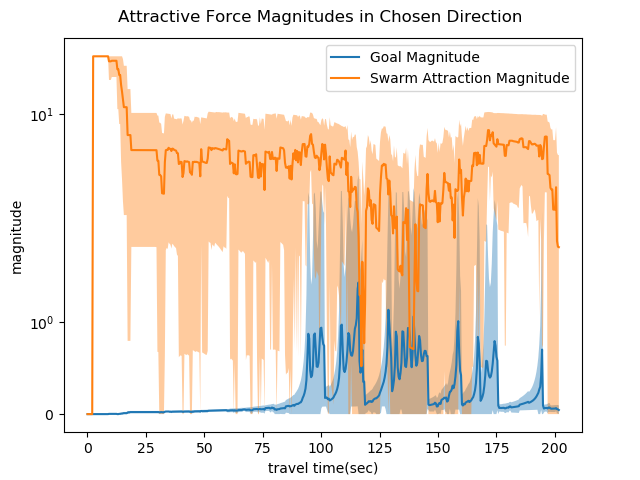

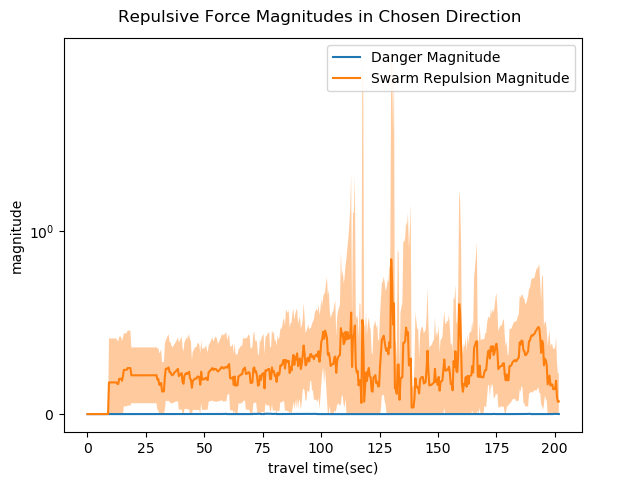

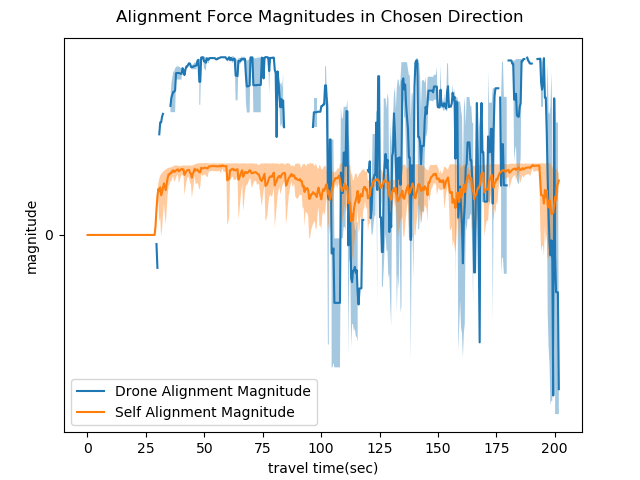

In [14]:
conSteer_debug_files = glob(path_lib.join(conSteer_path,"*_debug.csv"))

goal_mag,member_att_mag,member_rep_mag,danger_mag,align_mag,self_mag = ({},{},{},{},{},{})
for d_id,file_path in zip(drone_ids["conSteer"],conSteer_debug_files):
    df = pd.read_csv(file_path,skiprows=1)
    df.columns = [s.strip() for s in df.columns]
    goal_mag_sub,member_att_mag_sub,member_rep_mag_sub,danger_mag_sub,align_mag_sub,self_mag_sub = ([],[],[],[],[],[])
    for idx,timestamp in enumerate(timestamps):
        dir = int(df["choosen_dir"][idx])
        goal_mag_sub.append(math.sqrt(float(df[str(dir)+"_max_interest_force_x"][idx])**2+float(df[str(dir)+"_max_interest_force_y"][idx])**2))
        member_att_mag_sub.append(math.sqrt(float(df[str(dir)+"_max_member_att_force_x"][idx])**2+float(df[str(dir)+"_max_member_att_force_y"][idx])**2))
        member_rep_mag_sub.append(math.sqrt(float(df[str(dir)+"_max_member_rep_force_x"][idx])**2+float(df[str(dir)+"_max_member_rep_force_y"][idx])**2))
        danger_mag_sub.append(math.sqrt(float(df[str(dir)+"_max_danger_force_x"][idx])**2+float(df[str(dir)+"_max_danger_force_y"][idx])**2))
        align_mag_sub.append(float(df[str(dir)+"_align"][idx]))
        self_mag_sub.append(float(df[str(dir)+"_self_align"][idx]))
    goal_mag[d_id] = goal_mag_sub
    member_att_mag[d_id] = member_att_mag_sub
    member_rep_mag[d_id] = member_rep_mag_sub
    danger_mag[d_id] = danger_mag_sub
    align_mag[d_id] = align_mag_sub
    self_mag[d_id] = self_mag_sub
goal_mag = pd.DataFrame(goal_mag, index=timestamps)
member_att_mag = pd.DataFrame(member_att_mag, index=timestamps)
member_rep_mag = pd.DataFrame(member_rep_mag, index=timestamps)
danger_mag = pd.DataFrame(danger_mag, index=timestamps)
align_mag = pd.DataFrame(align_mag, index=timestamps) 
self_mag = pd.DataFrame(self_mag, index=timestamps)


for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.suptitle('Attractive Force Magnitudes in Chosen Direction')
    ax = plt.gca()
    ax.plot(timestamps,goal_mag.mean(axis=1).to_numpy(),label="Goal Magnitude")
    ax.fill_between(timestamps,np.maximum((goal_mag.mean(axis=1)-goal_mag.std(axis=1)).to_numpy(),goal_mag.min(axis=1).to_numpy()), \
                    np.minimum((goal_mag.mean(axis=1)+goal_mag.std(axis=1)).to_numpy(),goal_mag.max(axis=1).to_numpy()),alpha=0.4)
    ax.plot(timestamps,member_att_mag.mean(axis=1).to_numpy(),label="Swarm Attraction Magnitude")
    ax.fill_between(timestamps,np.maximum((member_att_mag.mean(axis=1)-member_att_mag.std(axis=1)).to_numpy(),member_att_mag.min(axis=1).to_numpy()), \
                    np.minimum((member_att_mag.mean(axis=1)+member_att_mag.std(axis=1)).to_numpy(),member_att_mag.max(axis=1).to_numpy()),alpha=0.4)
    plt.yscale("symlog")
    plt.xlabel("travel time(sec)")
    plt.ylabel("magnitude")
    plt.legend()
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.91)
    if it==0: plt.show()
    else: 
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_att_mag.png"))
        plt.clf()
        plt.close()

    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.suptitle('Repulsive Force Magnitudes in Chosen Direction')
    ax = plt.gca()
    ax.plot(timestamps,danger_mag.mean(axis=1).to_numpy(),label="Danger Magnitude")
    ax.fill_between(timestamps,np.maximum((danger_mag.mean(axis=1)-danger_mag.std(axis=1)).to_numpy(),danger_mag.min(axis=1).to_numpy()), \
                    np.minimum((danger_mag.mean(axis=1)+danger_mag.std(axis=1)).to_numpy(),danger_mag.max(axis=1).to_numpy()),alpha=0.4)
    ax.plot(timestamps,member_rep_mag.mean(axis=1).to_numpy(),label="Swarm Repulsion Magnitude")
    ax.fill_between(timestamps,np.maximum((member_rep_mag.mean(axis=1)-member_rep_mag.std(axis=1)).to_numpy(),member_rep_mag.min(axis=1).to_numpy()), \
                    np.minimum((member_rep_mag.mean(axis=1)+member_rep_mag.std(axis=1)).to_numpy(),member_rep_mag.max(axis=1).to_numpy()),alpha=0.4)
    plt.yscale("symlog")
    plt.xlabel("travel time(sec)")
    plt.ylabel("magnitude")
    plt.legend()
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.91)
    if it==0: plt.show()
    else: 
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_rep_mag.png"))
        plt.clf()
        plt.close()
    
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.suptitle('Alignment Force Magnitudes in Chosen Direction')
    ax = plt.gca()
    ax.plot(timestamps,align_mag.mean(axis=1).to_numpy(),label="Drone Alignment Magnitude")
    ax.fill_between(timestamps,np.maximum((align_mag.mean(axis=1)-align_mag.std(axis=1)).to_numpy(),align_mag.min(axis=1).to_numpy()), \
                    np.minimum((align_mag.mean(axis=1)+align_mag.std(axis=1)).to_numpy(),align_mag.max(axis=1).to_numpy()),alpha=0.4)
    ax.plot(timestamps,self_mag.mean(axis=1).to_numpy(),label="Self Alignment Magnitude")
    ax.fill_between(timestamps,np.maximum((self_mag.mean(axis=1)-self_mag.std(axis=1)).to_numpy(),self_mag.min(axis=1).to_numpy()), \
                    np.minimum((self_mag.mean(axis=1)+self_mag.std(axis=1)).to_numpy(),self_mag.max(axis=1).to_numpy()),alpha=0.4)
    plt.yscale("symlog")
    plt.xlabel("travel time(sec)")
    plt.ylabel("magnitude")
    plt.legend()
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.91)
    if it==0: plt.show()
    else: 
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_align_mag.png"))
        plt.clf()
        plt.close();

Main Evaluation Plot

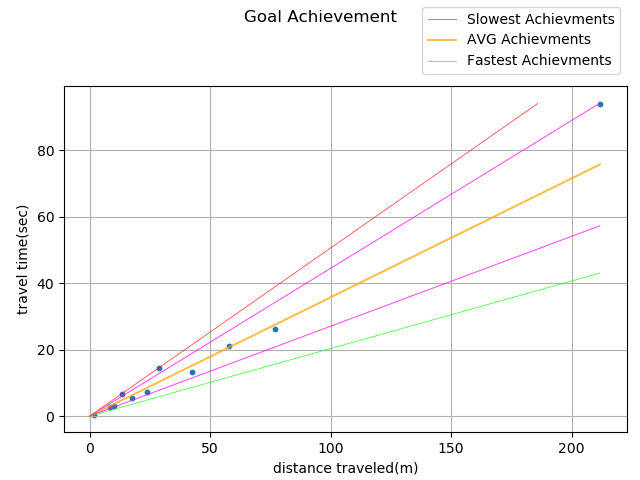

In [15]:
if reached:
    for it in range(2):
        if it==0: plt.figure()
        else: plt.figure(dpi=1200)
        significant_points = [slowest_goal,fastest_goal]
        sig_time,sig_dist,max_time,max_dist = ([],[],0,0)
        for point in significant_points:
            for dist,time in reached.values():
                if time/dist==point:
                    sig_time.append(time)
                    sig_dist.append(dist)
                if time > max_time: max_time = time
                if dist > max_dist: max_dist = dist
        plt.plot([0,sig_dist[0],min(max_time/max(slowest_goal,0.001),max_dist)],[0,sig_time[0],min(max_time,max_dist*slowest_goal)],c='red',label='Slowest Achievments',alpha=0.7,linewidth=0.6)
        plt.plot([0,min(max_time/(avg_goal+std_goal),max_dist)],[0,min(max_time,max_dist*(avg_goal+std_goal))],c='magenta',alpha=0.7,linewidth=0.75)
        plt.plot([0,min(max_time/avg_goal,max_dist)],[0,min(max_time,max_dist*avg_goal)],label='AVG Achievments',c='orange',alpha=0.7)
        plt.plot([0,min(max_time/max((avg_goal-std_goal),0.001),max_dist)],[0,min(max_time,max_dist*max((avg_goal-std_goal),0))],c='magenta',alpha=0.7,linewidth=0.75)
        plt.plot([0,sig_dist[1],min(max_time/max(fastest_goal,0.001),max_dist)],[0,sig_time[1],min(max_time,max_dist*fastest_goal)],c='lime',label='Fastest Achievments',alpha=0.7,linewidth=0.6)
        plt.scatter([tuplett[0] for tuplett in reached.values()],[tuplett[1] for tuplett in reached.values()],s=10)
        plt.suptitle('Goal Achievement')
        plt.ylabel("travel time(sec)")
        plt.xlabel("distance traveled(m)")
        plt.legend(bbox_to_anchor=(1.0,1.25))
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.82,right=0.98)
        plt.grid()
        if it==0: plt.show()
        else:     
            plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_goal.png"))
            plt.clf()
            plt.close();
else:
    print("No Goal Reached!") 

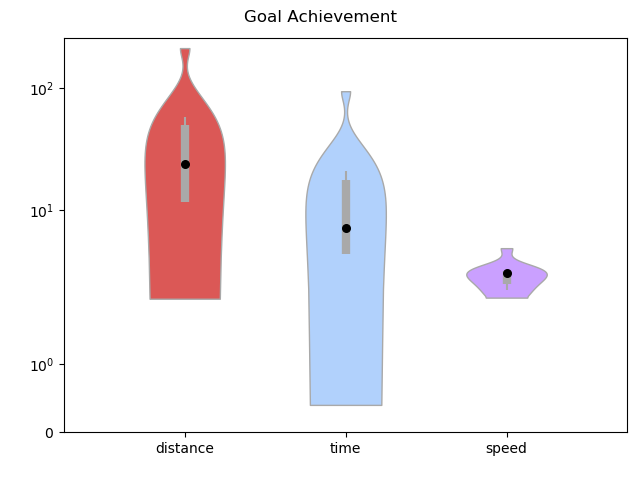

In [16]:
if reached:
    dist,time,speed = ([],[],[])
    for tuplett in reached.values():
        dist.append(tuplett[0])
        time.append(tuplett[1])
        speed.append(0 if tuplett[1]==0 else tuplett[0]/tuplett[1])
    for it in range(2):
        if it==0: plt.figure()
        else: plt.figure(dpi=1200)
        plt.suptitle('Goal Achievement')
        data = [dist,time,speed]
        ax = plt.gca()
        parts = ax.violinplot(data,showmeans=False,showextrema=False,showmedians=False)
        for idx,pc in enumerate(parts['bodies']):
            if idx==0: pc.set_facecolor('#DB5856')
            elif idx==1: pc.set_facecolor('#B1D1FC')
            else: pc.set_facecolor('#CAA0FF')
            pc.set_edgecolor('darkgrey')
            pc.set_alpha(1)
        quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
        inds = np.arange(1, len(medians) + 1)
        plt.scatter(inds, medians, marker='o', color='black', s=30, zorder=3)
        plt.vlines(inds, quartile1, quartile3, color='darkgrey', linestyle='-', lw=6)
        plt.vlines(inds, whiskers_min, whiskers_max, color='darkgrey', linestyle='-', lw=1.5)
        labels = ['distance','time','speed']
        ax.xaxis.set_tick_params(direction='out')        
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(0.25,len(labels)+0.75)
        ax.set_ylim(0,max(np.max(dist),np.max(time))+0.2*max(np.max(dist),np.max(time)))
        plt.xticks(np.arange(1,len(labels)+1), labels)
        plt.yscale("symlog")
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        if it==0: plt.show()
        else:     
            plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_goal_dist.png"))
            plt.clf()
            plt.close();
else:
    print("No Goal Reached!") 

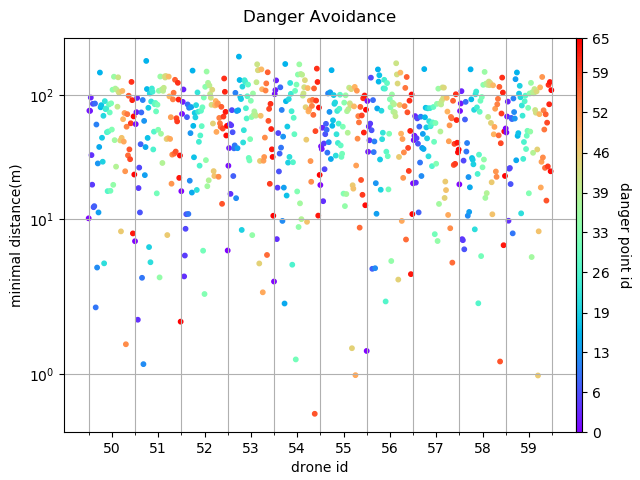

In [17]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.suptitle('Danger Avoidance')
    plt.xticks([*range(int(len(scene["rep"])/2),len(min_dist),len(scene["rep"]))], drone_ids["conSteer"])
    plt.yscale("symlog")
    ax = plt.gca()
    colors = np.array([*range(len(scene["rep"]))]*len(drone_ids["conSteer"]))*10
    plot = ax.scatter([*range(len(min_dist))],[tuplett[1] for tuplett in min_dist.values()],c=colors,cmap='rainbow',s=10) 
    ax.set_ylabel("minimal distance(m)")
    ax.set_xlabel("drone id")
    ax.set_xticks([*range(0,len(min_dist),len(scene["rep"])),len(min_dist)], minor=True)
    ax.xaxis.grid(which='minor',alpha=1.0)
    ax.yaxis.grid(alpha=1.0)
    cticks = [*[int(num) for num in np.arange(0,len(scene["rep"]),len(scene["rep"])/10)*10], (len(scene["rep"])-1)*10]
    cbar = plt.colorbar(plot, cax=plt.axes([0.90, 0.10, 0.01, 0.82]), cmap='rainbow', ticks=cticks)
    cbar.ax.set_yticklabels([str(int(ctick/10)) for ctick in cticks])
    cbar.ax.set_ylabel('danger point id',rotation=270,labelpad=15)
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.90)
    if it==0: plt.show()
    else: 
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_danger.png"))
        plt.clf()
        plt.close();

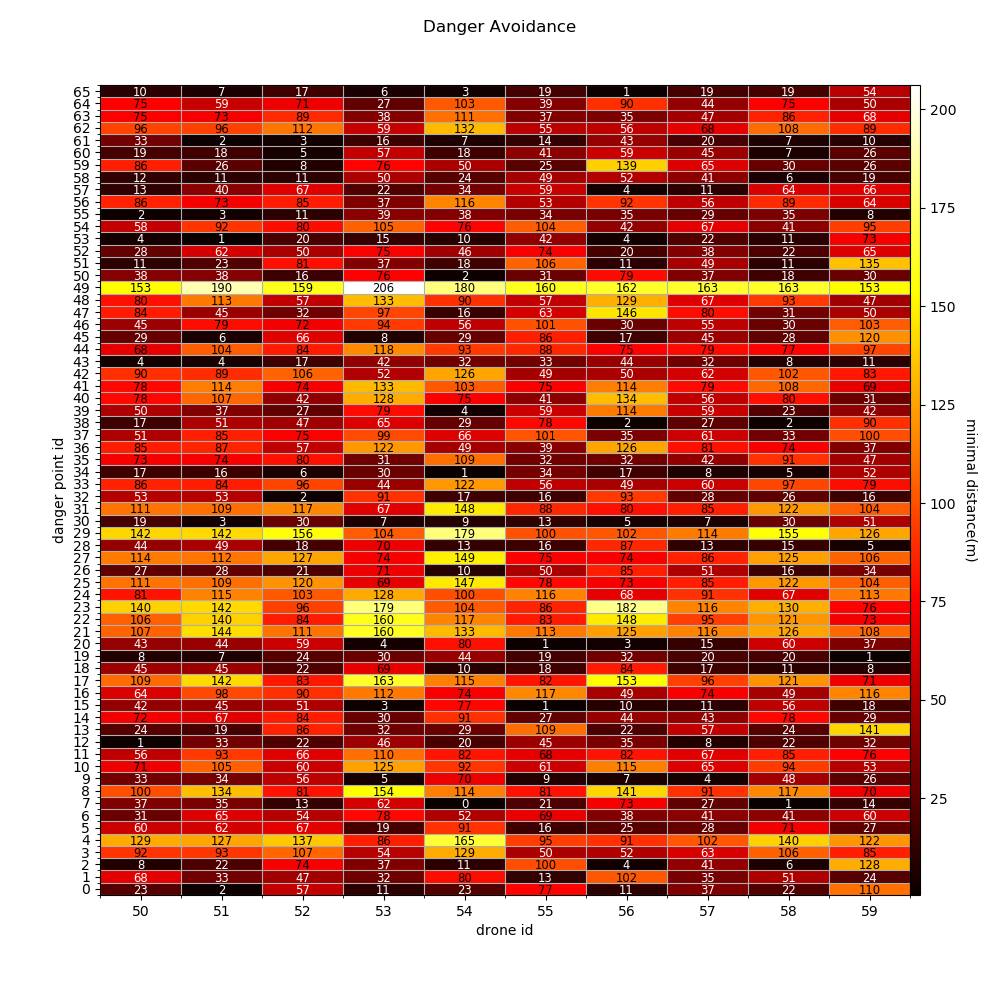

: 

: 

In [18]:
data = np.zeros((len(scene["rep"]),len(drone_ids["conSteer"])))
for key,tuplett in min_dist.items():
    data[len(scene["rep"])-(int(key.split("<->")[1])+1),drone_ids["conSteer"].index(int(key.split("<->")[0]))] = tuplett[1]
for it in range(2):
    if it==0:
        fig = plt.figure()  
    else:
        fig = plt.figure(dpi=1200)
    fig.set_size_inches(10,10)
    plt.suptitle('Danger Avoidance') 
    x_ticks = np.arange((10/len(drone_ids["conSteer"]))/2,10,10/len(drone_ids["conSteer"]))
    y_ticks = np.arange((10/len(scene["rep"]))/2,10,10/len(scene["rep"]))
    plt.xticks(x_ticks, drone_ids["conSteer"])
    plt.yticks(y_ticks,[*range(len(scene["rep"]))])
    ax = fig.gca()
    im = ax.imshow(data,cmap='hot',extent=[0,10,0,10],aspect='equal',origin='lower')
    ax.set_xticks(np.arange(0,10+10/len(drone_ids["conSteer"]),10/len(drone_ids["conSteer"])), minor=True)
    ax.set_yticks(np.arange(0,10+10/len(scene["rep"]),10/len(scene["rep"])),minor=True)
    ax.xaxis.grid(which='minor',alpha=1.0)
    ax.yaxis.grid(which='minor',alpha=1.0)
    ax.set_ylabel('danger point id')
    ax.set_xlabel('drone id')     
    for y in range(len(scene["rep"])):
        for x in range(len(drone_ids["conSteer"])):
            ax.text(x=x_ticks[x], y=y_ticks[y], s=str(round(data[y,x])), fontsize='small',
            ha="center",va="center_baseline",color='white' if data[y,x]/furthest_dist<0.33 else 'black')
    cbar = ax.figure.colorbar(im,ax=ax,cax=plt.axes([0.91, 0.105, 0.01, 0.81]),cmap='hot')
    cbar.ax.set_ylabel('minimal distance(m)',rotation=270,labelpad=15)
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.91)
    if it==0: plt.show()
    else: 
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_danger_heatmap.png"))
        plt.clf()
        plt.close();

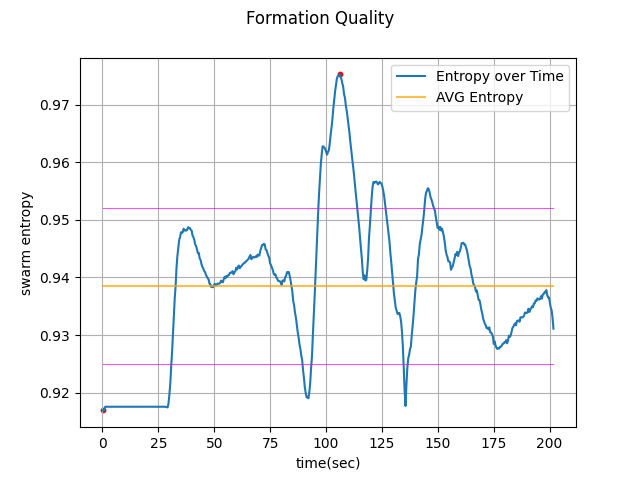

In [ ]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.plot(timestamps,entropy,label='Entropy over Time')
    plt.plot([timestamps[0],timestamps[-1]],[avg_entropy+std_entropy,avg_entropy+std_entropy],c='magenta',alpha=0.7,linewidth=0.75)
    plt.plot([timestamps[0],timestamps[-1]],[avg_entropy,avg_entropy],label='AVG Entropy',c='orange',alpha=0.7)
    plt.plot([timestamps[0],timestamps[-1]],[avg_entropy-std_entropy,avg_entropy-std_entropy],c='magenta',alpha=0.7,linewidth=0.75)
    significant_points = [smallest_entropy,largest_entropy]
    plt.scatter([timestamps[entropy.index(point)] for point in significant_points],significant_points,c='red',s=10)
    plt.suptitle('Formation Quality')
    plt.ylabel("swarm entropy")
    plt.xlabel("time(sec)")
    plt.legend()
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_entropy.png"))
        plt.clf()
        plt.close();

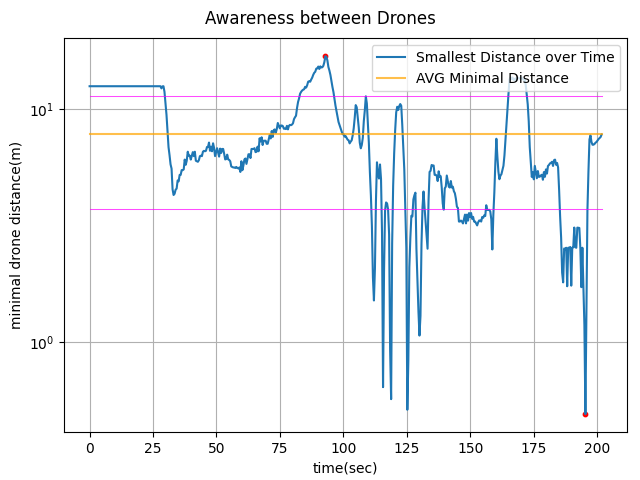

In [ ]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.plot(timestamps,dr_min_dist,label="Smallest Distance over Time")
    plt.plot([timestamps[0],timestamps[-1]],[avg_ddist+std_ddist,avg_ddist+std_ddist],c='magenta',alpha=0.7,linewidth=0.75)
    plt.plot([timestamps[0],timestamps[-1]],[avg_ddist,avg_ddist],label='AVG Minimal Distance',c='orange',alpha=0.7)
    plt.plot([timestamps[0],timestamps[-1]],[avg_ddist-std_ddist,avg_ddist-std_ddist],c='magenta',alpha=0.7,linewidth=0.75)
    significant_points = [smallest_ddist,furthest_ddist]
    plt.scatter([timestamps[dr_min_dist.index(point)] for point in significant_points],significant_points,c='red',s=10)
    plt.suptitle('Awareness between Drones')
    plt.ylabel("minimal drone distance(m)")
    plt.yscale('symlog')
    plt.xlabel("time(sec)")
    plt.legend(loc='upper right')
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
    if it==0: plt.show()
    else:     
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_drones.png"))
        plt.clf()
        plt.close();

# Evaluation of Attraction-Repulsion Behaviour

In [ ]:
drone_protocol = dict()
timestamps = list()

for d_id,file_path in zip(drone_ids["attRep"],attRep_files):
    drone_protocol[d_id] = dict()
    with open(file_path,"r") as file:
        d_timestamps = list()
        lines = file.readlines()
        for line in lines[1:-1]:
            key = float(line.split("]")[0].strip("[").strip())
            pos = [float(coord.strip()) for coord in line.split("pos:")[-1].split("/")[0].split(",")]
            drone_protocol[d_id][key] = pos
            d_timestamps.append(key)
        if d_id == drone_ids["attRep"][0]: timestamps = d_timestamps
        else: timestamps = [timestamp for timestamp in timestamps if timestamp in d_timestamps]

print(drone_protocol.keys())
for key in drone_protocol.keys():
    print("-> protocol from drone "+str(key)+": ")
    print("   first_timestamp:",list(drone_protocol[key].keys())[0])
    print("   first_pos:",drone_protocol[key][list(drone_protocol[key].keys())[0]])
    print("   timestamp_amount:",len(drone_protocol[key].keys()))


dict_keys([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
-> protocol from drone 30: 
   first_timestamp: 0.066436
   first_pos: [52.13741233, 11.64344738]
   timestamp_amount: 3476
-> protocol from drone 31: 
   first_timestamp: 0.066436
   first_pos: [52.13832758, 11.64424225]
   timestamp_amount: 3476
-> protocol from drone 32: 
   first_timestamp: 0.066436
   first_pos: [52.1379485, 11.64414748]
   timestamp_amount: 3476
-> protocol from drone 33: 
   first_timestamp: 0.066436
   first_pos: [52.13788361, 11.6438589]
   timestamp_amount: 3476
-> protocol from drone 34: 
   first_timestamp: 0.066436
   first_pos: [52.13754893, 11.64466657]
   timestamp_amount: 3475
-> protocol from drone 35: 
   first_timestamp: 0.066436
   first_pos: [52.13873397, 11.64502772]
   timestamp_amount: 3476
-> protocol from drone 36: 
   first_timestamp: 0.066436
   first_pos: [52.13779824, 11.64446081]
   timestamp_amount: 3476
-> protocol from drone 37: 
   first_timestamp: 0.066436
   first_pos: [52.1381773

In [ ]:
scene = dict()

with open(scene_path, "r") as file:
    lines = file.readlines()
    for line in lines[2:]:
        vals = [val.strip() for val in line.split(",")]
        scene[vals[-1]] = scene.get(vals[-1], [])
        scene[vals[-1]].append([round(float(vals[0]),8),round(float(vals[1]),8)])

print(scene.keys())
for key in scene.keys():
    print("-> "+str(key)+"s in scene: ")
    print("   first_"+str(key)+":",scene[key][0])
    print("   "+str(key)+"_amount:",len(scene[key]))

dict_keys(['rep', 'att', 'spawn'])
-> reps in scene: 
   first_rep: [52.13927302, 11.64744523]
   rep_amount: 66
-> atts in scene: 
   first_att: [52.13967268, 11.64772695]
   att_amount: 6
-> spawns in scene: 
   first_spawn: [52.13741576, 11.64344715]
   spawn_amount: 10


Attraction Point Achievement Analysis

In [ ]:
reached = {}
last_att_time = 0
last_drone_pos = [drone_protocol[d_id][timestamps[0]] for d_id in drone_protocol.keys()]
for timestamp in timestamps:
    for d_id in drone_protocol.keys():
        for att_id, att in enumerate(scene["att"]):
            if getDistance(*drone_protocol[d_id][timestamp],*att) < 1.5 \
            and not reached.get(str(d_id)+"->"+str(att_id), None):
                reached[str(d_id)+"->"+str(att_id)] = [getDistance(*last_drone_pos[drone_ids["attRep"].index(d_id)],*att),timestamp-last_att_time]
                last_drone_pos = [drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()]
                last_att_time = timestamp

for key in reached.keys():
    print("Drone",key.split("->")[0],"reached ATT Point",key.split("->")[1],"approximately after",
    str(reached[key][1])+"sec and {:.8f}m of travel.".format(reached[key][0]))

Drone 32 reached ATT Point 0 approximately after 174.644608sec and 310.53407075m of travel.
Drone 38 reached ATT Point 0 approximately after 0.6878049999999973sec and 3.89118930m of travel.
Drone 34 reached ATT Point 0 approximately after 0.6252900000000068sec and 3.08941107m of travel.
Drone 37 reached ATT Point 0 approximately after 0.25010599999998817sec and 2.21628685m of travel.
Drone 39 reached ATT Point 0 approximately after 0.8753969999999924sec and 4.25093933m of travel.
Drone 37 reached ATT Point 1 approximately after 37.704375999999996sec and 95.43788419m of travel.
Drone 39 reached ATT Point 1 approximately after 0.9379280000000279sec and 5.26184830m of travel.


Repulsion Zone Avoidance Analysis

In [ ]:
min_dist = {}
for timestamp in timestamps:
    for d_id in drone_protocol.keys():
        for rep_id, rep in enumerate(scene["rep"]):
            dist = getDistance(*drone_protocol[d_id][timestamp],*rep)
            if not min_dist.get(str(d_id)+"<->"+str(rep_id), None) \
            or dist < min_dist[str(d_id)+"<->"+str(rep_id)][1]:
                min_dist[str(d_id)+"<->"+str(rep_id)] = [timestamp, dist]

for key in min_dist.keys():
    print("Smallest distance between Drone",key.split("<->")[0],"and REP Point",key.split("<->")[1],
    "was {0:.8f}m and occured".format(round(min_dist[key][1],8)),
    "{0:.6f}sec after simulation start.".format(min_dist[key][0]))

Smallest distance between Drone 30 and REP Point 0 was 25.68627078m and occured 155.073349sec after simulation start.
Smallest distance between Drone 30 and REP Point 1 was 54.38044356m and occured 50.776646sec after simulation start.
Smallest distance between Drone 30 and REP Point 2 was 61.19167287m and occured 82.228226sec after simulation start.
Smallest distance between Drone 30 and REP Point 3 was 73.12483380m and occured 103.362694sec after simulation start.
Smallest distance between Drone 30 and REP Point 4 was 52.69430728m and occured 129.124222sec after simulation start.
Smallest distance between Drone 30 and REP Point 5 was 38.19090224m and occured 88.168388sec after simulation start.
Smallest distance between Drone 30 and REP Point 6 was 5.59796351m and occured 39.834244sec after simulation start.
Smallest distance between Drone 30 and REP Point 7 was 28.80938280m and occured 88.168388sec after simulation start.
Smallest distance between Drone 30 and REP Point 8 was 9.49542

Swarming Analysis

In [ ]:
entropy = list()
for timestamp in timestamps:
    drone_pos = np.array([drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()])
    centeroid = np.average(drone_pos,axis=0)
    dist = np.linalg.norm(drone_pos - centeroid, axis=1)
    probs = dist/np.sum(dist)
    entropy.append(-np.sum(probs*np.log2(probs))/np.log2(len(drone_ids["attRep"])))
print("Average Entropy: {:.4f} - std: {:.4f}".format(np.average(entropy),np.std(entropy)))


Average Entropy: 0.9249 - std: 0.0338


In [ ]:
dr_min_dist = list()
drone_pairs = list()
for timestamp in timestamps:
    drone_pos = np.array([drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()])
    min_drone_dist = dict()
    for i,d_pos in enumerate(drone_pos):
        dists = dict()
        for j,o_pos in enumerate(drone_pos[i+1:]):
            if d_pos[0]-o_pos[0] == 0 and d_pos[1]-o_pos[1] == 0: dists[0] = str(i)+"<->"+str(j+i+1)
            else: dists[abs(getDistance(*d_pos,*o_pos))] = str(i)+"<->"+str(j+i+1)
        if dists: min_drone_dist[np.min(list(dists.keys()))] = dists[np.min(list(dists.keys()))]
    dr_min_dist.append(np.min(list(min_drone_dist.keys())))
    drone_pairs.append(min_drone_dist[dr_min_dist[-1]])

for key,dist,time in zip(drone_pairs[::75],dr_min_dist[::75],timestamps[::75]):
    print("Smallest distance between Drone",str(drone_ids["attRep"][int(key.split("<->")[0])]),"and Drone",
    str(drone_ids["attRep"][int(key.split("<->")[1])]),"was {0:.8f}m and occured".format(round(dist,8)),
    "{0:.6f}sec after simulation start.".format(time))

Smallest distance between Drone 32 and Drone 39 was 13.25767272m and occured 0.066436sec after simulation start.
Smallest distance between Drone 32 and Drone 39 was 13.25767272m and occured 4.756036sec after simulation start.
Smallest distance between Drone 32 and Drone 39 was 13.25767272m and occured 9.445636sec after simulation start.
Smallest distance between Drone 32 and Drone 39 was 13.25767272m and occured 14.135236sec after simulation start.
Smallest distance between Drone 32 and Drone 39 was 13.25767272m and occured 18.824837sec after simulation start.
Smallest distance between Drone 32 and Drone 39 was 13.25767272m and occured 23.514437sec after simulation start.
Smallest distance between Drone 32 and Drone 39 was 13.25767272m and occured 28.204037sec after simulation start.
Smallest distance between Drone 36 and Drone 39 was 7.16116781m and occured 32.893635sec after simulation start.
Smallest distance between Drone 32 and Drone 39 was 1.58857138m and occured 37.583237sec aft

Behaviour Evaluation

In [ ]:
# Attraction Stats
fastest_att,slowest_att,avg_att,std_att,percentiles_att = (-1,-1,-1,-1,[-1,-1,-1])
if reached:
    fastest_att = min([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    slowest_att = max([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    avg_att = np.average([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    std_att = np.std([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    percentiles_att = np.percentile([tuplett[1]/tuplett[0] for tuplett in reached.values()],[25,50,75])

    print("Attraction Stats:\n-----------")
    print("Shortest travel time to attraction point: {:>5.2f} sec/m".format(round(fastest_att,2)))
    print("Average travel time to attraction point:  {:>5.2f} sec/m".format(round(avg_att,2)))
    print("Longest travel time to attraction point:  {:>5.2f} sec/m".format(round(slowest_att,2)))
    print("Standard Deviation in travel times:       {:>5.2f} sec/m".format(round(std_att,2)))
    print("First percentile(Q1) in travel times:     {:>5.2f} sec/m".format(round(percentiles_att[0],2)))
    print("Median(2nd percentile) in travel times:   {:>5.2f} sec/m".format(round(percentiles_att[1],2)))
    print("Third percentile(Q3) in travel times:     {:>5.2f} sec/m".format(round(percentiles_att[2],2)))
else:
    print("No Attraction Points Reached!")


Attraction Stats:
-----------
Shortest travel time to attraction point:  0.11 sec/m
Average travel time to attraction point:   0.26 sec/m
Longest travel time to attraction point:   0.56 sec/m
Standard Deviation in travel times:        0.15 sec/m
First percentile(Q1) in travel times:      0.18 sec/m
Median(2nd percentile) in travel times:    0.20 sec/m
Third percentile(Q3) in travel times:      0.30 sec/m


In [ ]:
# Repulsion Stats
smallest_dist = min([tuplett[1] for tuplett in min_dist.values()])
furthest_dist = max([tuplett[1] for tuplett in min_dist.values()])
avg_dist = np.average([tuplett[1] for tuplett in min_dist.values()])
std_dist = np.std([tuplett[1] for tuplett in min_dist.values()])
percentiles_dist = np.percentile([tuplett[1] for tuplett in min_dist.values()],[25,50,75])

print("\nRepulsion Stats:\n-------------")
print("Smallest minimal distance to repulsion center: {:>6.2f} m".format(round(smallest_dist,2)))
print("Average minimal distance to repulsion center:  {:>6.2f} m".format(round(avg_dist,2)))
print("Furthest minimal distance to repulsion center: {:>6.2f} m".format(round(furthest_dist,2)))
print("Standard Deviation in minimal distances:       {:>6.2f} m".format(round(std_dist,2)))
print("First percentile(Q1) in minimal distances:     {:>6.2f} m".format(round(percentiles_dist[0],2)))
print("Median(2nd percentile) in minimal distances:   {:>6.2f} m".format(round(percentiles_dist[1],2)))
print("Third percentile(Q3) in minimal distances:     {:>6.2f} m".format(round(percentiles_dist[2],2)))


Repulsion Stats:
-------------
Smallest minimal distance to repulsion center:   0.38 m
Average minimal distance to repulsion center:   75.70 m
Furthest minimal distance to repulsion center: 238.77 m
Standard Deviation in minimal distances:        50.87 m
First percentile(Q1) in minimal distances:      34.69 m
Median(2nd percentile) in minimal distances:    62.56 m
Third percentile(Q3) in minimal distances:     111.19 m


In [ ]:
# Swarm Stats
smallest_entropy = min(entropy)
largest_entropy = max(entropy)
avg_entropy = np.average(entropy)
std_entropy = np.std(entropy)
percentiles_entropy = np.percentile(entropy,[25,50,75])

smallest_ddist = min(dr_min_dist)
furthest_ddist = max(dr_min_dist)
avg_ddist = np.average(dr_min_dist)
std_ddist = np.std(dr_min_dist)
percentiles_ddist = np.percentile(dr_min_dist,[25,50,75])

print("\nSwarm Stats:\n-------------")
print("Smallest entropy of swarm formation:         {:>6.4f}".format(round(smallest_entropy,4)))
print("Average entropy of swarm formation:          {:>6.4f}".format(round(avg_entropy,4)))
print("Largest entropy of swarm formation:          {:>6.4f}".format(round(largest_entropy,4)))
print("Standard Deviation in formation entropy:     {:>6.4f}".format(round(std_entropy,4)))
print("First percentile(Q1) in formation entropy:   {:>6.4f}".format(round(percentiles_entropy[0],4)))
print("Median(2nd percentile) in formation entropy: {:>6.4f}".format(round(percentiles_entropy[1],4)))
print("Third percentile(Q3) in formation entropy:   {:>6.4f}".format(round(percentiles_entropy[2],4)))
print("-----------------------------------------------------")
print("Smallest minimal distance to other drones:   {:>6.2f} m".format(round(smallest_ddist,2)))
print("Average minimal distance to other drones:    {:>6.2f} m".format(round(avg_ddist,2)))
print("Furthest minimal distance to other drones:   {:>6.2f} m".format(round(furthest_ddist,2)))
print("Standard Deviation in minimal distances:     {:>6.2f} m".format(round(std_ddist,2)))
print("First percentile(Q1) in minimal distances:   {:>6.2f} m".format(round(percentiles_ddist[0],2)))
print("Median(2nd percentile) in minimal distances: {:>6.2f} m".format(round(percentiles_ddist[1],2)))
print("Third percentile(Q3) in minimal distances:   {:>6.2f} m".format(round(percentiles_ddist[2],2)))


Swarm Stats:
-------------
Smallest entropy of swarm formation:         0.8105
Average entropy of swarm formation:          0.9249
Largest entropy of swarm formation:          0.9863
Standard Deviation in formation entropy:     0.0338
First percentile(Q1) in formation entropy:   0.9118
Median(2nd percentile) in formation entropy: 0.9291
Third percentile(Q3) in formation entropy:   0.9497
-----------------------------------------------------
Smallest minimal distance to other drones:     0.00 m
Average minimal distance to other drones:      2.93 m
Furthest minimal distance to other drones:    13.63 m
Standard Deviation in minimal distances:       4.38 m
First percentile(Q1) in minimal distances:     0.66 m
Median(2nd percentile) in minimal distances:   1.12 m
Third percentile(Q3) in minimal distances:     1.94 m


In [ ]:
# Save Stats to file
result_file_path = path_lib.join(log_path, "attRep_"+SCENE_NAME.strip(".csv")+"_res.csv")
with open(result_file_path, "w") as results:
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(slowest_att,12),round(avg_att,12),round(fastest_att,12),
        round(std_att,12),round(percentiles_att[0],12),
        round(percentiles_att[1],12),round(percentiles_att[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_dist,12),round(avg_dist,12),round(furthest_dist,12),
        round(std_dist,12),round(percentiles_dist[0],12),
        round(percentiles_dist[1],12),round(percentiles_dist[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_entropy,12),round(avg_entropy,12),round(largest_entropy,12),
        round(std_entropy,12),round(percentiles_entropy[0],12),
        round(percentiles_entropy[1],12),round(percentiles_entropy[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_ddist,12),round(avg_ddist,12),round(furthest_ddist,12),
        round(std_ddist,12),round(percentiles_ddist[0],12),
        round(percentiles_ddist[1],12),round(percentiles_ddist[2],12)))
print("Saved Results to",result_file_path)

Saved Results to C:\Users\nilst\Projects\FINkenSim\sharedFolder\paparazzi\logs\attRep_random_420_res.csv


Debug Magnitude Evaluation

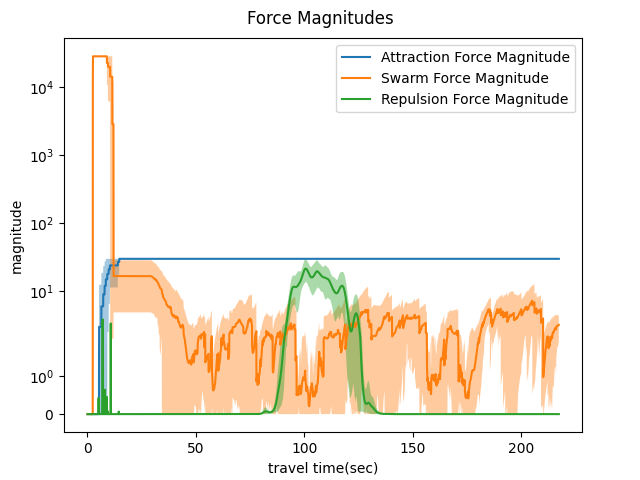

In [ ]:
attRep_debug_files = glob(path_lib.join(attRep_path,"*_debug.csv"))

att_mag,member_mag,rep_mag = ({},{},{})
for d_id,file_path in zip(drone_ids["attRep"],attRep_debug_files):
    df = pd.read_csv(file_path,skiprows=1)
    df.columns = [s.strip() for s in df.columns]
    att_mag_sub,member_mag_sub,rep_mag_sub = ([],[],[])
    for timestamp in timestamps:
        att_mag_sub.append(math.sqrt(float(df["att_force_x"][timestamp])**2+float(df["att_force_y"][timestamp])**2))
        member_mag_sub.append(math.sqrt(float(df["member_force_x"][timestamp])**2+float(df["member_force_y"][timestamp])**2))
        rep_mag_sub.append(math.sqrt(float(df["rep_force_x"][timestamp])**2+float(df["rep_force_y"][timestamp])**2))
    att_mag[d_id] = att_mag_sub
    member_mag[d_id] = member_mag_sub
    rep_mag[d_id] = rep_mag_sub
att_mag = pd.DataFrame(att_mag, index=timestamps)
member_mag = pd.DataFrame(member_mag, index=timestamps)
rep_mag = pd.DataFrame(rep_mag, index=timestamps)


for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.suptitle('Force Magnitudes')
    ax = plt.gca()
    ax.plot(timestamps,att_mag.mean(axis=1).to_numpy(),label="Attraction Force Magnitude")
    ax.fill_between(timestamps,np.maximum((att_mag.mean(axis=1)-att_mag.std(axis=1)).to_numpy(),att_mag.min(axis=1).to_numpy()), \
                    np.minimum((att_mag.mean(axis=1)+att_mag.std(axis=1)).to_numpy(),att_mag.max(axis=1).to_numpy()),alpha=0.4)
    ax.plot(timestamps,member_mag.mean(axis=1).to_numpy(),label="Swarm Force Magnitude")
    ax.fill_between(timestamps,np.maximum((member_mag.mean(axis=1)-member_mag.std(axis=1)).to_numpy(),member_mag.min(axis=1).to_numpy()), \
                    np.minimum((member_mag.mean(axis=1)+member_mag.std(axis=1)).to_numpy(),member_mag.max(axis=1).to_numpy()),alpha=0.4)
    ax.plot(timestamps,rep_mag.mean(axis=1).to_numpy(),label="Repulsion Force Magnitude")
    ax.fill_between(timestamps,np.maximum((rep_mag.mean(axis=1)-rep_mag.std(axis=1)).to_numpy(),rep_mag.min(axis=1).to_numpy()), \
                    np.minimum((rep_mag.mean(axis=1)+rep_mag.std(axis=1)).to_numpy(),rep_mag.max(axis=1).to_numpy()),alpha=0.4)
    plt.yscale("symlog")
    plt.xlabel("travel time(sec)")
    plt.ylabel("magnitude")
    plt.legend()
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.91)
    if it==0: plt.show()
    else: 
        plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_mag.png"))
        plt.clf()
        plt.close();

Main Evaluation Plots

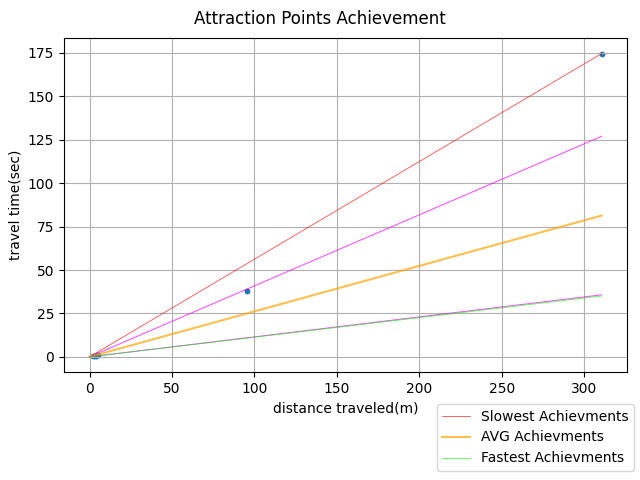

In [ ]:
if reached:
    for it in range(2):
        if it==0: plt.figure()
        else: plt.figure(dpi=1200)
        significant_points = [slowest_att,fastest_att]
        sig_time,sig_dist,max_time,max_dist = ([],[],0,0)
        for point in significant_points:
            for dist,time in reached.values():
                if time/dist==point:
                    sig_time.append(time)
                    sig_dist.append(dist)
                if time > max_time: max_time = time
                if dist > max_dist: max_dist = dist
        plt.plot([0,sig_dist[0],min(max_time/max(slowest_att,0.001),max_dist)],[0,sig_time[0],min(max_time,max_dist*slowest_att)],c='red',label='Slowest Achievments',alpha=0.7,linewidth=0.6)
        plt.plot([0,min(max_time/(avg_att+std_att),max_dist)],[0,min(max_time,max_dist*(avg_att+std_att))],c='magenta',alpha=0.7,linewidth=0.75)
        plt.plot([0,min(max_time/avg_att,max_dist)],[0,min(max_time,max_dist*avg_att)],label='AVG Achievments',c='orange',alpha=0.7)
        plt.plot([0,min(max_time/max((avg_att-std_att),0.001),max_dist)],[0,min(max_time,max_dist*max((avg_att-std_att),0))],c='magenta',alpha=0.7,linewidth=0.75)
        plt.plot([0,sig_dist[1],min(max_time/max(fastest_att,0.001),max_dist)],[0,sig_time[1],min(max_time,max_dist*fastest_att)],c='lime',label='Fastest Achievments',alpha=0.7,linewidth=0.6)
        plt.scatter([tuplett[0] for tuplett in reached.values()],[tuplett[1] for tuplett in reached.values()],s=10)
        plt.suptitle('Attraction Points Achievement')
        plt.ylabel("travel time(sec)")
        plt.xlabel("distance traveled(m)")
        plt.legend(bbox_to_anchor=(1.025,-0.075))
        plt.subplots_adjust(left=0.10,bottom=0.225,top=0.92,right=0.98)
        plt.grid()
        if it==0: plt.show()
        else:     
            plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_att.png"))
            plt.clf()
            plt.close();
else:
    print("No Attraction Point Reached!") 

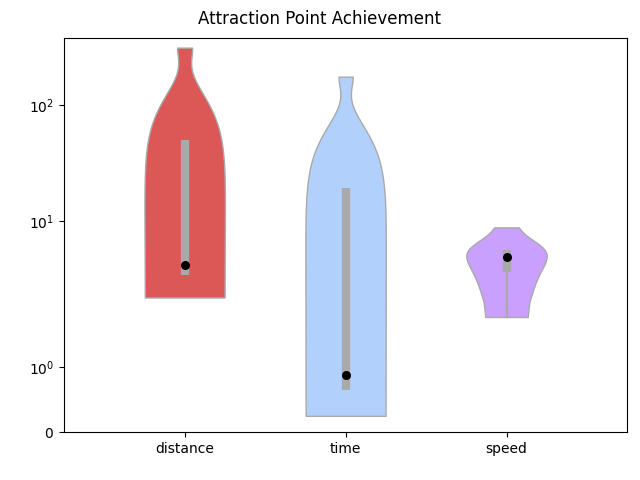

In [ ]:
if reached:
    dist,time,speed = ([],[],[])
    for tuplett in reached.values():
        dist.append(tuplett[0])
        time.append(tuplett[1])
        speed.append(0 if tuplett[1]==0 else tuplett[0]/tuplett[1])
    for it in range(2):
        if it==0: plt.figure()
        else: plt.figure(dpi=1200)
        plt.suptitle('Attraction Point Achievement')
        data = [dist,time,speed]
        ax = plt.gca()
        parts = ax.violinplot(data,showmeans=False,showextrema=False,showmedians=False)
        for idx,pc in enumerate(parts['bodies']):
            if idx==0: pc.set_facecolor('#DB5856')
            elif idx==1: pc.set_facecolor('#B1D1FC')
            else: pc.set_facecolor('#CAA0FF')
            pc.set_edgecolor('darkgrey')
            pc.set_alpha(1)
        quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
        inds = np.arange(1, len(medians) + 1)
        plt.scatter(inds, medians, marker='o', color='black', s=30, zorder=3)
        plt.vlines(inds, quartile1, quartile3, color='darkgrey', linestyle='-', lw=6)
        plt.vlines(inds, whiskers_min, whiskers_max, color='darkgrey', linestyle='-', lw=1.5)
        labels = ['distance','time','speed']
        ax.xaxis.set_tick_params(direction='out')        
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(0.25,len(labels)+0.75)
        ax.set_ylim(0,max(np.max(dist),np.max(time))+max(np.max(dist),np.max(time))*0.2)
        plt.xticks(np.arange(1,len(labels)+1), labels)
        plt.yscale("symlog")
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        if it==0: plt.show()
        else:     
            plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_att_dist.png"))
            plt.clf()
            plt.close();
else:
    print("No Attraction Point Reached!")

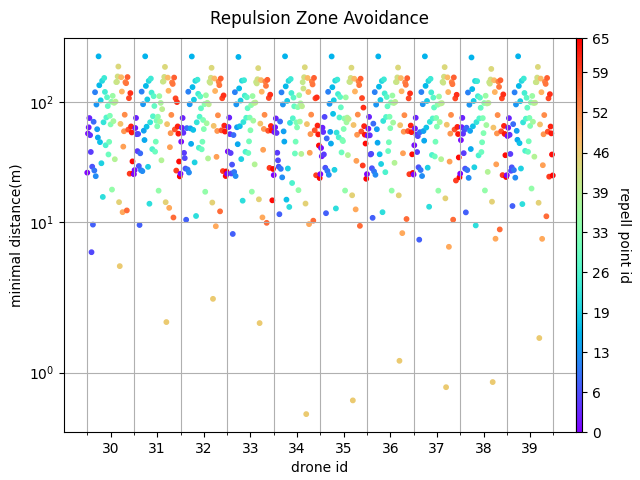

In [ ]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.suptitle('Repulsion Zone Avoidance')
    plt.xticks([*range(int(len(scene["rep"])/2),len(min_dist),len(scene["rep"]))], drone_ids["attRep"])
    plt.yscale("symlog")
    ax = plt.gca()
    colors = np.array([*range(len(scene["rep"]))]*len(drone_ids["attRep"]))*10
    plot = ax.scatter([*range(len(min_dist))],[tuplett[1] for tuplett in min_dist.values()],c=colors,cmap='rainbow',s=10) 
    ax.set_ylabel("minimal distance(m)")
    ax.set_xlabel("drone id")
    ax.set_xticks([*range(0,len(min_dist),len(scene["rep"])),len(min_dist)], minor=True)
    ax.xaxis.grid(which='minor',alpha=1.0)
    ax.yaxis.grid(alpha=1.0)
    cticks = [*[int(num) for num in np.arange(0,len(scene["rep"]),len(scene["rep"])/10)*10], (len(scene["rep"])-1)*10]
    cbar = plt.colorbar(plot, cax=plt.axes([0.90, 0.10, 0.01, 0.82]), cmap='rainbow', ticks=cticks)
    cbar.ax.set_yticklabels([str(int(ctick/10)) for ctick in cticks])
    cbar.ax.set_ylabel('repell point id',rotation=270,labelpad=15)
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.90)
    if it==0: plt.show()
    else: 
        plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_rep.png"))
        plt.clf()
        plt.close();

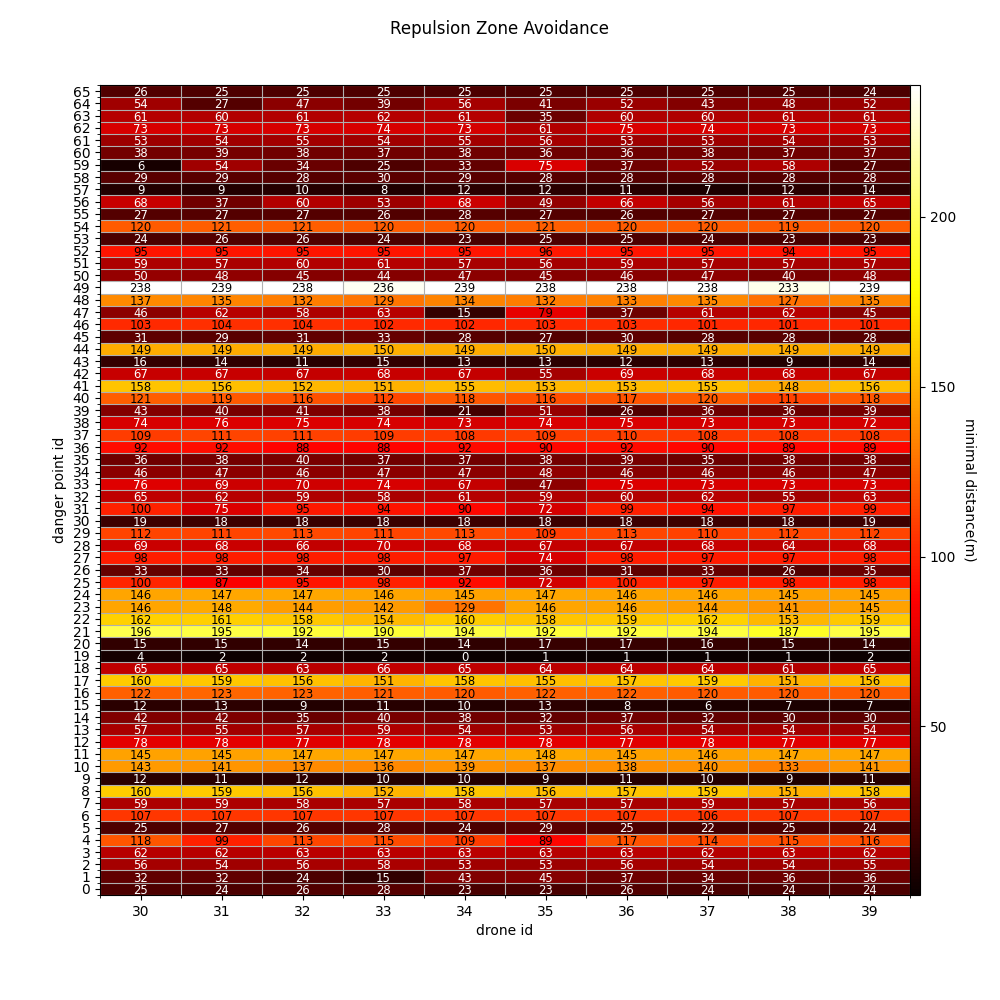

In [ ]:
data = np.zeros((len(scene["rep"]),len(drone_ids["attRep"])))
for key,tuplett in min_dist.items():
    data[len(scene["rep"])-(int(key.split("<->")[1])+1),drone_ids["attRep"].index(int(key.split("<->")[0]))] = tuplett[1]
for it in range(2):
    fig = plt.figure() if it==0 else plt.figure(dpi=1200)
    fig.set_size_inches(10,10)
    plt.suptitle('Repulsion Zone Avoidance') 
    x_ticks = np.arange((10/len(drone_ids["attRep"]))/2,10,10/len(drone_ids["attRep"]))
    y_ticks = np.arange((10/len(scene["rep"]))/2,10,10/len(scene["rep"]))
    plt.xticks(x_ticks, drone_ids["attRep"])
    plt.yticks(y_ticks,[*range(len(scene["rep"]))])
    ax = fig.gca()
    im = ax.imshow(data,cmap='hot',extent=[0,10,0,10],aspect='equal',origin='lower')
    ax.set_xticks(np.arange(0,10+10/len(drone_ids["attRep"]),10/len(drone_ids["attRep"])), minor=True)
    ax.set_yticks(np.arange(0,10+10/len(scene["rep"]),10/len(scene["rep"])),minor=True)
    ax.xaxis.grid(which='minor',alpha=1.0)
    ax.yaxis.grid(which='minor',alpha=1.0)
    ax.set_ylabel('danger point id')
    ax.set_xlabel('drone id')     
    for y in range(len(scene["rep"])):
        for x in range(len(drone_ids["attRep"])):
            ax.text(x=x_ticks[x], y=y_ticks[y], s=str(round(data[y,x])), fontsize='small',
            ha="center",va="center_baseline",color='white' if data[y,x]/furthest_dist<0.33 else 'black')
    cbar = ax.figure.colorbar(im,ax=ax,cax=plt.axes([0.91, 0.105, 0.01, 0.81]),cmap='hot')
    cbar.ax.set_ylabel('minimal distance(m)',rotation=270,labelpad=15)
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.91)
    if it==0: plt.show()
    else: 
        plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_rep_heatmap.png"))
        plt.clf()
        plt.close();

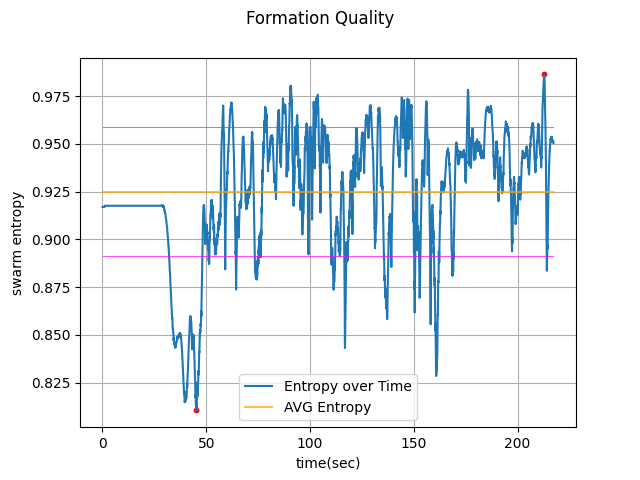

In [ ]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.plot(timestamps,entropy,label='Entropy over Time')
    plt.plot([timestamps[0],timestamps[-1]],[avg_entropy+std_entropy,avg_entropy+std_entropy],c='magenta',alpha=0.7,linewidth=0.75)
    plt.plot([timestamps[0],timestamps[-1]],[avg_entropy,avg_entropy],label='AVG Entropy',c='orange',alpha=0.7)
    plt.plot([timestamps[0],timestamps[-1]],[avg_entropy-std_entropy,avg_entropy-std_entropy],c='magenta',alpha=0.7,linewidth=0.75)
    significant_points = [smallest_entropy,largest_entropy]
    plt.scatter([timestamps[entropy.index(point)] for point in significant_points],significant_points,c='red',s=10)
    plt.suptitle('Formation Quality')
    plt.ylabel("swarm entropy")
    plt.xlabel("time(sec)")
    plt.legend()
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_entropy.png"))
        plt.clf()
        plt.close();

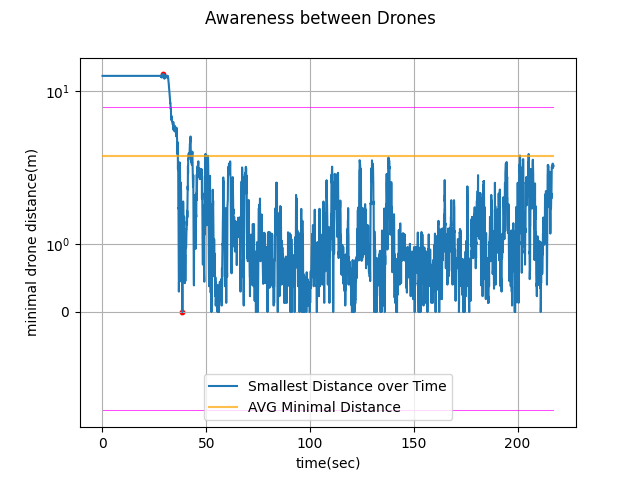

In [ ]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.yscale("symlog")
    plt.plot(timestamps,dr_min_dist,label="Smallest Distance over Time")
    plt.plot([timestamps[0],timestamps[-1]],[avg_ddist+std_ddist,avg_ddist+std_ddist],c='magenta',alpha=0.7,linewidth=0.75)
    plt.plot([timestamps[0],timestamps[-1]],[avg_ddist,avg_ddist],label='AVG Minimal Distance',c='orange',alpha=0.7)
    plt.plot([timestamps[0],timestamps[-1]],[avg_ddist-std_ddist,avg_ddist-std_ddist],c='magenta',alpha=0.7,linewidth=0.75)
    significant_points = [smallest_ddist,furthest_ddist]
    plt.scatter([timestamps[dr_min_dist.index(point)] for point in significant_points],significant_points,c='red',s=10)
    plt.suptitle('Awareness between Drones')
    plt.ylabel("minimal drone distance(m)")
    plt.xlabel("time(sec)")
    plt.legend()
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_drones.png"))
        plt.clf()
        plt.close();